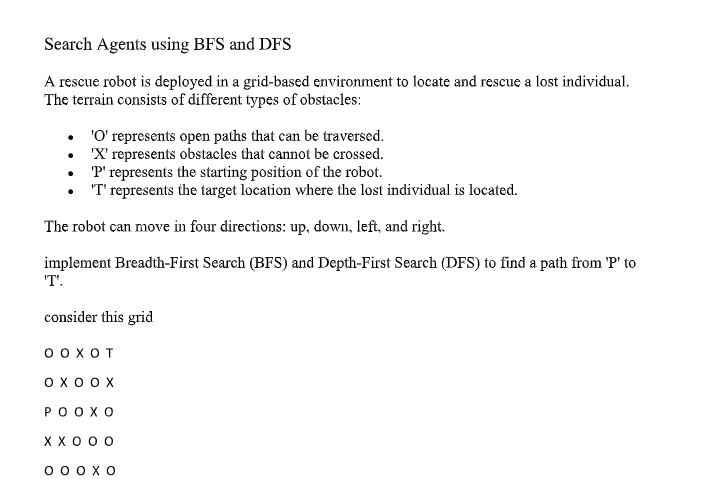

In [ ]:
O, X, P, T = ['O', 'X', 'P', 'T']

class Environment:
  def __init__(self, grid: list[list[str]]):
    self.grid = grid

  def get_percept(self, start: str):
    for r in range(len(self.grid)):
      for c in range(len(self.grid[0])):
        if self.grid[r][c] != start:
          continue
        return (r, c)
    return None

  def is_goal(self, state: tuple[int, int], goal: str):
    u, v = state
    return self.grid[u][v] == goal
  
  def get_neighbors(self, state: tuple[int, int]):
    return filter(lambda curr: 0 <= curr[0] < len(self.grid) and 0 <= curr[1] < len(self.grid[0]) and self.grid[curr[0]][curr[1]] != X, map(lambda curr: (curr[0] + state[0], curr[1] + state[1]), [(0,1), (1,0), (-1,0), (0,-1)]))
  
  def dfs(self, source: tuple[int, int], goal: str):
    st = [(source, [source])]
    visited = set()

    while st:
      state, path = st.pop()

      if self.is_goal(state, goal):
        return path

      visited.add(state)
      for new_state in self.get_neighbors(state):
        if new_state not in visited:
          st.append((new_state, path + [new_state]))
    return None

class Agent:
  def __init__(self, goal: str):
    self.goal = goal

  def act(self, source: tuple[int, int], env: Environment):
    return env.dfs(source, self.goal)

def run_agent(env: Environment, agent: Agent, source: str):
  percept = env.get_percept(source)
  if percept:
    actions = agent.act(percept, env)
  print(actions)

grid=[
  [O, O, X, O, T],
  [O, X, O, O, X],
  [P, O, O, X, O],
  [X, X, O, O, O],
  [O, O, O, X, O]
]

env = Environment(grid)
agent = Agent(T)
run_agent(env, agent, P)

[(2, 0), (2, 1), (2, 2), (1, 2), (1, 3), (0, 3), (0, 4)]


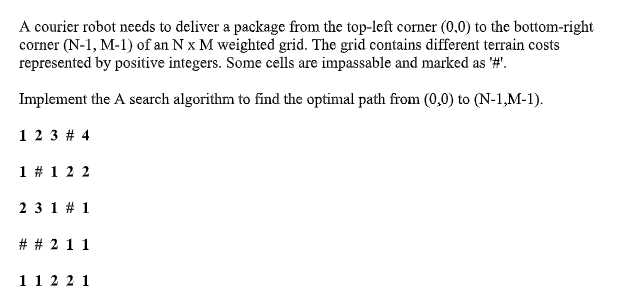

In [120]:
import heapq

def manhattan(curr: tuple[int, int], dest: tuple[int, int]):
  return abs(curr[0] - dest[0]) + abs(curr[1] - dest[1])

def A_search(grid: list[list[int | str]], source: tuple[int, int], goal: tuple[int, int]):
  n, m = len(grid), len(grid[0])
  pq = [(0, source)]
  dist: dict[tuple[int, int], tuple[int, tuple[int, int]]] = {source: (0, None)}

  def construct_path():
    path = []
    curr = goal
    while curr:
      path.append(curr)
      d, p = dist.get(curr)
      curr = p
    return path[::-1]
  
  while pq:
    d, (u, v)= heapq.heappop(pq)

    if (u, v) == goal:
      return construct_path()

    for du, dv in [(0,1), (1,0), (0,-1), (-1,0)]:
      nu, nv = u + du, v + dv
      if not (0 <= nu < n and 0 <= nv < m and grid[nu][nv] != '#'):
        continue
      w = d + grid[nu][nv]
      if w < dist.get((nu, nv), (float('inf'), None))[0]:
        dist[(nu, nv)] = (w, (u, v))
        heapq.heappush(pq, (w + manhattan((nu, nv), goal), (nu, nv)))
  return None

grid = [
  [1, 2, 3, '#', 4],
  [1, '#', 1, 2, 2],
  [2, 3, 1, '#', 1],
  ['#', '#', 2, 1, 1],
  [1, 1, 2, 2, 1]
]

A_search(grid, (0, 0), (len(grid)-1, len(grid[0])-1))

[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (3, 2), (3, 3), (3, 4), (4, 4)]

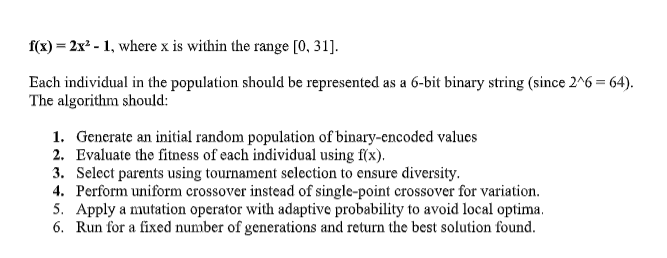

In [ ]:
import bisect
import random
import itertools

def to_int(bstr: str):
  return int(bstr, 2)

def to_bin(num: int):
  return format(num, '06b')

def flip(c: str):
  return '1' if c == '0' else '0'

def initial_population(n: int = 10):
  return [to_bin(random.randrange(0, 32)) for _ in range(n)]

def f(x: int):
  return 2 * x**2 - 1

def selection(population: list[str], fitness: dict[str, int], k=3):
  """ tournament: assuming k is the tournaments """
  # sample = random.sample(population, k)
  # return sorted(sample, key=lambda ind: fitness[ind])[:2]
  """ truncation: assuming k is the truncation limit """
  # return sorted(population, key=lambda ind: fitness[ind])[:k]
  """ roulette wheel """
  total_fitness = sum(fitness.values())
  probabilities = [fitness.get(ind) / total_fitness for ind in population]
  psum = list(itertools.accumulate(probabilities))
  return population[bisect.bisect(psum, random.random())]

def crossover(parent1: str, parent2: str):
  n = len(parent1) & len(parent2)
  """ uniform """
  # return ''.join(parent1[i] if random.random() < 0.5 else parent2[i] for i in range(n))
  """ single point """
  # this was in case uniqueness doesnt matter
  # point = random.randint(1, n-1)
  # return parent1[:point] + parent2[point:]
  # otherwise
  # point = random.randint(1, n - 1)
  # child = parent1[:point]
  # child += [gen for gen in parent2 if gen not in child]
  """ two point """
  point1 = random.randint(1, n-2)
  point2 = random.randint(point1+1, n-1)
  return parent1[:point1] + parent2[point1:point2] + parent1[point2:] 
  # otherwise
  # point1 = random.randint(1, n - 2)
  # point2 = random.randint(point1 + 1, n - 1)
  # child = parent1[point1:point2]
  # prefix = [gen for gen in parent2 if gen not in child]
  # suffix = [gen for gen in parent2 if gen not in child and gen not in prefix]
  # return prefix + child + suffix

def mutate(individual: str, mutation_rate: float):
  return ''.join(flip(c) if random.random() < mutation_rate else c for c in individual)

def run_genetic(generations: int, population_size: int, mutation_rate: float = 0.01):
  population = initial_population(population_size)
  fitness = {x: f(to_int(x)) for x in population}

  for generation in range(generations):
    new_population = []
    for _ in range(population_size):
      parent1 = selection(population, fitness, 2)
      parent2 = selection(population, fitness, 2)
      child1 = crossover(parent1, parent2)
      child2 = crossover(parent1, parent2)
      mutation_rate = 0.01 + (generation / generations) * 0.05
      new_population += [mutate(child1, mutation_rate), mutate(child2, mutation_rate)]
    
    population = new_population
    fitness = {x: f(to_int(x)) for x in population}

    print(f'gen: {generation + 1} >> best: {max(fitness, key=fitness.get)}')

  best = max(fitness, key=fitness.get)
  return best

run_genetic(10, 10)

gen: 1 >> best: 111010
gen: 2 >> best: 011110
gen: 3 >> best: 011011
gen: 4 >> best: 011010
gen: 5 >> best: 011010
gen: 6 >> best: 011010
gen: 7 >> best: 011010
gen: 8 >> best: 011110
gen: 9 >> best: 111100
gen: 10 >> best: 111110


'111110'